## **Initial Setup: Google Drive Mount**

This cell sets up access to Google Drive where the dataset is stored.

- **`from google.colab import drive`**: Imports the Google Colab drive module for mounting Google Drive
- **`drive.mount('/content/drive')`**: Mounts your Google Drive to the `/content/drive` directory, allowing the notebook to access files stored in Drive
- **`import pandas as pd`**: Imports pandas, which we'll use for data manipulation throughout this notebook

After running this cell, you'll need to authenticate with Google to grant access to your Drive. This is a one-time setup step in Google Colab.


In [ ]:
#import and mount drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Step 2: Data Exploration**

This cell explores the unique values in key categorical columns to understand the data distribution:

- **`Data['roles'].unique()`**: Shows all unique role combinations (e.g., ["CEO"], ["CEO", "CTO"]) - founders can have multiple roles
- **`Data['preferred_role'].unique()`**: Shows the single preferred role for each founder (CEO, CTO, COO, CPO)
- **`Data['industry'].unique()`**: Displays all industries represented in the dataset (Fintech, Healthtech, SaaS, etc.)
- **`Data['secondary_industries'].unique()`**: Shows secondary industries (most are empty, some have values like ["Fintech"])

This exploration helps us understand:
1. The structure of multi-label columns (like `roles`) vs single-label columns (like `preferred_role`)
2. The diversity of industries and roles in the dataset
3. What preprocessing steps will be needed (e.g., parsing JSON-like strings for multi-label columns)


In [ ]:
Data=pd.read_csv('/content/drive/MyDrive/INDENG 242A/founders_dataset.csv')
display(pd.DataFrame(Data.columns))


,0
0,roles
1,preferred_role
2,industry
3,secondary_industries
4,years_of_experience
5,is_technical
6,education_level
7,tech_stack
8,strengths
9,weaknesses


In [ ]:
#Data[Data['secondary_industries']!='[]']

print(Data['roles'].unique())
print(Data['preferred_role'].unique())
print(Data['industry'].unique())
print(Data['secondary_industries'].unique())

['["COO"]' '["CEO"]' '["CTO"]' '["CPO"]' '["CEO", "CPO"]' '["CEO", "CTO"]'
 '["COO", "CPO"]' '["CEO", "COO"]' '["COO", "CTO"]' '["CPO", "COO"]'
 '["CTO", "COO"]' '["CTO", "CPO"]' '["CPO", "CEO"]' '["CPO", "CTO"]']
['COO' 'CEO' 'CTO' 'CPO']
['Other' 'Gaming / Entertainment' 'Consumer / Social' 'Fintech'
 'Marketplaces' 'Climate / Greentech' 'Edtech' 'E-commerce'
 'AI / Deeptech' 'Healthtech' 'Web3 / Crypto' 'Biotech' 'SaaS']
['[]' '["Fintech"]']


## **Step 3: Library Imports for Machine Learning**

This cell imports essential libraries for the collaborative filtering implementation:

- **`ast`**: Used to safely parse string representations of Python lists (e.g., converting `'["CEO", "CTO"]'` to actual list `["CEO", "CTO"]`)
- **`numpy`**: Provides numerical computing capabilities and array operations
- **`pandas`**: Data manipulation and analysis
- **`MultiLabelBinarizer`**: Encodes multi-label categorical data (where one sample can belong to multiple categories) into binary feature vectors
- **`StandardScaler`**: Standardizes features by removing the mean and scaling to unit variance (important for numerical features with different scales)
- **`normalize`**: L2-normalizes vectors to unit length (necessary for cosine similarity calculations)
- **`cosine_similarity`**: Computes cosine similarity between vectors (measures angle between vectors, useful for measuring similarity)
- **`train_test_split`**: Splits data into training, validation, and test sets for model evaluation


In [ ]:
import ast
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin


### **Step 3.1: Data Overview**

This cell provides a quick overview of the dataset:

- **`df = Data`**: Assigns the loaded data to a simpler variable name `df` for easier reference
- **`df.shape`**: Returns a tuple (rows, columns) showing the dimensions of the dataset
  - Output: `(1209, 25)` means we have 1209 founders and 25 features/columns
- **`df.head()`**: Displays the first 5 rows of the DataFrame, giving us a preview of the data structure and values

This helps verify that the data loaded correctly and gives us an initial sense of the dataset size and content.


In [ ]:
# Path to your file
df = Data
print(df.shape)
df.head()


(1209, 25)


,roles,preferred_role,industry,secondary_industries,years_of_experience,is_technical,education_level,tech_stack,strengths,weaknesses,...,gender,collaboration_openness_score,communication_intensity_score,responsiveness_score,risk_tolerance,leadership,autonomy,vision,communication,execution_speed
0,"[""COO""]",COO,Other,[],4,False,bachelor,"[""Swift"", ""Node.js""]","[""User empathy"", ""Communication skills"", ""Anal...","[""Risk-averse"", ""Impatient with slow processes""]",...,M,0.036290,0.024107,0.143475,2,2,3,3,3,4
1,"[""CEO""]",CEO,Gaming / Entertainment,[],7,True,self-taught,"[""Unity"", ""C#"", ""JavaScript"", ""Webflow""]","[""User empathy"", ""Team-building"", ""Creativity ...","[""Poor work-life balance"", ""Limited business e...",...,M,0.031654,0.010418,0.177019,4,2,3,4,5,5
2,"[""CEO""]",CEO,Consumer / Social,[],3,False,bachelor,"[""React"", ""Node.js"", ""Firebase""]","[""Creativity and vision"", ""High ownership"", ""P...","[""Overly detail-oriented"", ""Weak in sales""]",...,M,0.022029,0.003984,0.092243,4,5,4,3,5,3
3,"[""COO""]",COO,Fintech,[],12,False,master,"[""Figma"", ""Swift"", ""Notion"", ""AWS""]","[""High ownership"", ""Resilience"", ""Fast executi...","[""Overly optimistic"", ""Easily distracted by ne...",...,M,0.277378,0.036848,0.127754,4,2,2,4,4,5
4,"[""CTO""]",CTO,Other,[],2,True,bachelor,"[""AWS"", ""Django"", ""Swift"", ""Docker""]","[""Resilience"", ""Scrappiness"", ""Strong leadersh...","[""Overly detail-oriented"", ""Poor work-life bal...",...,M,0.195837,0.125118,0.038137,4,3,3,2,4,3


## **Step 4: Feature Preprocessing Overview**

Before we can compute similarities and complementarities between founders, we need to convert all their attributes into numerical feature matrices. This involves:

1. **Feature Classification**: Split features into two categories:
   - **Similarity features**: Features where similarity matters (e.g., industry, collaboration_openness_score, communication_intensity_score, responsiveness_score, risk_tolerance, vision, communication, execution_speed)
   - **Complementarity features**: Features where complementarity matters (e.g., tech_stack, strengths, weaknesses, role, preferred_roles, years_of_experience, education_level)

2. **Multi-label encoding**: Columns like `roles` and `tech_stack` contain lists (e.g., `["CEO", "CTO"]`) that need to be converted to binary feature vectors
3. **One-hot encoding**: Single categorical columns like `industry` and `preferred_role` need to be converted to binary indicators
4. **Numeric scaling**: Numerical features need to be standardized so they're on the same scale
5. **L2 normalization**: For similarity features, normalize each founder's feature vector to unit length for cosine similarity
6. **Complementarity computation**: For complementarity features, compute complementarity scores based on differences

The result will be:
- **X_similarity**: Matrix for similarity features (normalized for cosine similarity)
- **X_complementarity**: Matrix for complementarity features (used for complementarity computation)
- **Sij**: Similarity matrix using cosine similarity on similarity features
- **Cij**: Complementarity matrix using complementarity measure on complementarity features
- **Rij**: Combined rating matrix = Sij + Cij (or weighted combination)


### **Step 4.1: Column Classification by Type and Similarity/Complementarity**

This cell categorizes all columns in the dataset by their data type AND by whether they represent similarity or complementarity:

**By Data Type:**
- **`multi_label_cols`**: Columns that contain lists of values (e.g., a founder can have multiple roles, multiple technologies in their tech stack, multiple strengths/weaknesses). These need special handling using MultiLabelBinarizer.

- **`single_cat_cols`**: Columns with single categorical values (e.g., each founder has one preferred role, one industry, one education level). These will be one-hot encoded using `pd.get_dummies()`.

- **`numeric_cols`**: Numerical features that will be standardized (e.g., years of experience, age, various scores). These represent continuous or ordinal data.

**By Similarity/Complementarity:**
- **`similarity_features`**: Features where similarity matters (industry, collaboration_openness_score, communication_intensity_score, responsiveness_score, risk_tolerance, vision, communication, execution_speed)
- **`complementarity_features`**: Features where complementarity matters (tech_stack, strengths, weaknesses, role, preferred_roles, years_of_experience, education_level)

- **`FOUNDER_ID_COL`**: The identifier column that uniquely identifies each founder.

This dual classification is crucial because:
1. Different column types require different preprocessing approaches
2. Similarity and complementarity features need different computation methods


In [ ]:
# ---- 4.1: specify columns by type and similarity/complementarity ----
multi_label_cols = [
    'roles',
    'secondary_industries',
    'tech_stack',
    'strengths',
    'weaknesses'
]

single_cat_cols = [
    'preferred_role',
    'industry',
    'education_level',
    'gender'
]

numeric_cols = [
    'years_of_experience',
    'is_technical',
    'age',
    'collaboration_openness_score',
    'communication_intensity_score',
    'responsiveness_score',
    'risk_tolerance',
    'leadership',
    'autonomy',
    'vision',
    'communication',
    'execution_speed'
]

# Features where similarity matters (use cosine similarity)
similarity_features = [
    'industry',  # single categorical
    'collaboration_openness_score',  # numeric
    'communication_intensity_score',  # numeric
    'responsiveness_score',  # numeric
    'risk_tolerance',  # numeric
    'vision',  # numeric
    'communication',  # numeric
    'execution_speed'  # numeric
]

# Features where complementarity matters (use complementarity measure)
complementarity_features = [
    'tech_stack',  # multi-label
    'strengths',  # multi-label
    'weaknesses',  # multi-label
    'roles',  # multi-label
    'preferred_role',  # single categorical
    'years_of_experience',  # numeric
    'education_level'  # single categorical
]

FOUNDER_ID_COL = 'founder_id'


### **Step 4.2: Parsing Multi-Label Columns**

This cell converts string representations of lists into actual Python lists:

- **`df[col].fillna('[]')`**: Replaces missing values with empty list string `'[]'` to avoid errors during parsing
- **`ast.literal_eval()`**: Safely evaluates a string containing a Python literal (like `'["CEO", "CTO"]'`) and converts it to an actual Python list `["CEO", "CTO"]`. This is safer than `eval()` as it only evaluates literals, not arbitrary code.

For example:
- Input: `'["CEO", "CTO"]'` (string)
- Output: `["CEO", "CTO"]` (list)

This transformation is necessary because when CSV files store lists, they're stored as strings, but we need actual list objects for the MultiLabelBinarizer to work.


In [ ]:
# ---- 4.2: parse multi-label columns (JSON-like strings -> Python lists) ----
for col in multi_label_cols:
    df[col] = df[col].fillna('[]').apply(ast.literal_eval)

df[multi_label_cols].head(2)


,roles,secondary_industries,tech_stack,strengths,weaknesses
0,[COO],[],"[Swift, Node.js]","[User empathy, Communication skills, Analytica...","[Risk-averse, Impatient with slow processes]"
1,[CEO],[],"[Unity, C#, JavaScript, Webflow]","[User empathy, Team-building, Creativity and v...","[Poor work-life balance, Limited business expe..."


### **Step 4.3: Multi-Label Binarization**

This cell converts multi-label columns (lists of values) into binary feature vectors:

**How MultiLabelBinarizer works:**
- For each column, it identifies all unique values across all rows
- Each row is converted to a binary vector where 1 indicates the presence of a value, 0 indicates absence
- Example: If a founder has `roles = ["CEO", "CTO"]` and all possible roles are `["CEO", "CTO", "COO", "CPO"]`, the output vector would be `[1, 1, 0, 0]`

**Process for each multi-label column:**
1. **`MultiLabelBinarizer()`**: Creates a new binarizer instance
2. **`mlb.fit_transform(df[col])`**: Fits the binarizer to learn all unique labels, then transforms the list column into a binary matrix
3. **`pd.DataFrame()`**: Converts the binary array into a DataFrame with meaningful column names (e.g., `roles__CEO`, `roles__CTO`)
4. All resulting DataFrames are stored in `multi_dfs` list for later concatenation

This creates binary features for each possible value in each multi-label column, allowing the model to capture which founders share similar roles, skills, or characteristics.


In [ ]:
# ---- 4.3: MultiLabelBinarizer for list-like columns ----
multi_dfs = []
for col in multi_label_cols:
    mlb = MultiLabelBinarizer()
    arr = mlb.fit_transform(df[col])
    multi_dfs.append(
        pd.DataFrame(
            arr,
            columns=[f"{col}__{c}" for c in mlb.classes_],
            index=df.index
        )
    )

len(multi_dfs), multi_dfs[0].shape


(5, (1209, 4))

### **Step 4.4-4.7: Creating Separate Feature Matrices for Similarity and Complementarity**

This cell creates two separate feature matrices - one for similarity features and one for complementarity features:

**Step 4.4: One-Hot Encoding for Single Categorical Columns**
- **`pd.get_dummies()`**: Converts each categorical column into multiple binary columns (one for each category)
  - Example: `industry` with values `["Fintech", "Healthtech"]` becomes two columns: `industry_Fintech` and `industry_Healthtech`
- **`.fillna("Unknown")`**: Handles missing values by replacing them with "Unknown" category
- **`prefix=single_cat_cols`**: Adds prefixes to column names to identify their source (e.g., `industry_Fintech` instead of just `Fintech`)

**Step 4.5: Numeric Feature Preparation**
- Creates a copy of numeric columns
- **`astype(int)`**: Converts boolean column `is_technical` to integer (True→1, False→0) so it can be treated as numeric

**Step 4.6: Split Features into Similarity and Complementarity Matrices**
- **Similarity features matrix**: Contains only features where similarity matters (industry, collaboration scores, etc.)
- **Complementarity features matrix**: Contains only features where complementarity matters (tech_stack, roles, years_of_experience, etc.)

**Step 4.7: Feature Matrix Assembly**
- **`features_similarity`**: Matrix for similarity features (will be normalized for cosine similarity)
- **`features_complementarity`**: Matrix for complementarity features (will be used for complementarity computation)

This separation allows us to compute similarity and complementarity separately, then combine them into the final rating matrix Rij.


In [ ]:
# ---- 4.4: One-hot encode single categorical columns ----
single_df = pd.get_dummies(
    df[single_cat_cols].fillna("Unknown"),
    prefix=single_cat_cols
)

# ---- 4.5: Numeric features (cast bool to int) ----
numeric_df = df[numeric_cols].copy()
if 'is_technical' in numeric_df.columns:
    numeric_df['is_technical'] = numeric_df['is_technical'].astype(int)

# ---- 4.6: Create separate feature matrices for similarity and complementarity ----
# First, create a mapping of which columns belong to which feature type
# For multi-label columns, we need to identify which binarized columns belong to which original column
multi_label_col_names = {}
for i, col in enumerate(multi_label_cols):
    mlb = MultiLabelBinarizer()
    mlb.fit(df[col])
    multi_label_col_names[col] = [f"{col}__{c}" for c in mlb.classes_]

# Build similarity features matrix
similarity_cols = []
# Add numeric similarity features
for col in similarity_features:
    if col in numeric_df.columns:
        similarity_cols.append(col)
# Add categorical similarity features (industry)
for col in similarity_features:
    if col in single_cat_cols:
        # Get columns from single_df that start with this prefix
        similarity_cols.extend([c for c in single_df.columns if c.startswith(f"{col}_")])

# Build complementarity features matrix
complementarity_cols = []
# Add numeric complementarity features
for col in complementarity_features:
    if col in numeric_df.columns:
        complementarity_cols.append(col)
# Add categorical complementarity features
for col in complementarity_features:
    if col in single_cat_cols:
        complementarity_cols.extend([c for c in single_df.columns if c.startswith(f"{col}_")])
# Add multi-label complementarity features
for col in complementarity_features:
    if col in multi_label_cols:
        complementarity_cols.extend(multi_label_col_names[col])

# Create the feature matrices
all_features = pd.concat([numeric_df, single_df] + multi_dfs, axis=1)

# Extract similarity and complementarity feature matrices
features_similarity = all_features[similarity_cols].copy()
features_complementarity = all_features[complementarity_cols].copy()

print("Similarity features matrix shape:", features_similarity.shape)
print("Complementarity features matrix shape:", features_complementarity.shape)
print("Total feature matrix shape:", all_features.shape)


Similarity features matrix shape: (1209, 20)
Complementarity features matrix shape: (1209, 117)
Total feature matrix shape: (1209, 144)


### **Step 4.8: Standardization and L2 Normalization**

This cell prepares the feature vectors for cosine similarity calculation:

**Standardization (Z-score normalization):**
- **`StandardScaler()`**: Creates a scaler that will transform features to have mean=0 and std=1
- **`scaler.fit_transform(features.values)`**:
  - **`fit`**: Computes the mean and standard deviation of each feature column from the training data
  - **`transform`**: Applies the transformation: `(x - mean) / std` for each feature
- **Why?**: Different features are on different scales (e.g., age might be 25-65, while scores might be 0-10). Standardization ensures all features contribute equally to similarity calculations.

**L2 Normalization:**
- **`normalize(X_std)`**: Normalizes each row (founder vector) to have unit length (L2 norm = 1)
- This is done by dividing each vector by its magnitude: `v_normalized = v / ||v||`
- **Why?**: Cosine similarity measures the angle between vectors, not their magnitude. Normalizing to unit length ensures we're only comparing directions, not sizes.

After this step, each founder is represented as a unit vector, and cosine similarity between two founders equals their dot product, making similarity computation efficient and interpretable.


Feature preprocessing (one-hot + multi-hot + scaling):

* parse list-like columns (e.g. ["Swift", "Node.js"])

* multi-hot encode them

* one-hot encode single categorical labels

* keep numeric features and scale them

* L2-normalize rows to prepare for cosine similarity

In [ ]:
# ---- 4.8.1: Standardize & L2-normalize similarity features ----
scaler_similarity = StandardScaler()
X_similarity_std = scaler_similarity.fit_transform(features_similarity.values)

# Normalize each founder vector to unit length for cosine similarity
from sklearn.preprocessing import normalize
X_similarity = normalize(X_similarity_std)

# ---- 4.8.2: Standardize complementarity features (no L2 normalization) ----
scaler_complementarity = StandardScaler()
X_complementarity_std = scaler_complementarity.fit_transform(features_complementarity.values)
X_complementarity = X_complementarity_std  # Keep standardized but not normalized

print("Similarity features shape (normalized):", X_similarity.shape)
print("Complementarity features shape (standardized):", X_complementarity.shape)


Similarity features shape (normalized): (1209, 20)
Complementarity features shape (standardized): (1209, 117)


## **Step 5: Building Similarity (Sij) and Complementarity (Cij) Matrices**

This section creates two separate matrices and then combines them:

**Step 5.1: Building Similarity Matrix (Sij)**
- Uses cosine similarity on similarity features (industry, collaboration scores, etc.)
- Measures how similar founders are in terms of industry, communication style, risk tolerance, etc.
- Range: -1 to 1, where 1 means identical, 0 means orthogonal, -1 means opposite

**Step 5.2: Building Complementarity Matrix (Cij)**
- Uses a complementarity measure on complementarity features (tech_stack, roles, years_of_experience, etc.)
- Measures how complementary founders are - different tech stacks, different roles, different experience levels
- For categorical/multi-label features: Uses Jaccard distance (1 - Jaccard similarity) to measure how different the sets are
- For numerical features: Uses normalized distance to measure how far apart they are on the spectrum
- Higher values indicate more complementary (different) founders

**Step 5.3: Combining Sij and Cij into Rij**
- **Rij = α * Sij + β * Cij**, where α and β are weights (default: α=0.5, β=0.5)
- Alternatively: **Rij = Sij + Cij** (simple addition after normalization)
- This combined matrix represents the overall compatibility score between founders
- We'll use Rij as our "ratings" matrix for collaborative filtering


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jaccard
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# ---- 5.1: Build Similarity Matrix (Sij) using cosine similarity ----
Sij = cosine_similarity(X_similarity)  # shape (n_founders, n_founders)
np.fill_diagonal(Sij, 0.0)  # remove trivial self-similarity

n_founders = Sij.shape[0]
print("Step 5.1: Similarity Matrix (Sij)")
print("  Shape:", Sij.shape)
print("  Min/Max:", float(Sij.min()), float(Sij.max()))
print("  Mean:", float(Sij.mean()))

# ---- 5.2: Build Complementarity Matrix (Cij) ----
def compute_complementarity_matrix(X_comp, features_df, complementarity_features):
    """
    Compute complementarity matrix where higher values mean more complementary (different).

    For categorical/multi-label features: Use Jaccard distance (1 - Jaccard similarity)
    For numerical features: Use normalized distance
    """
    n = X_comp.shape[0]
    Cij = np.zeros((n, n))

    # Map original feature names to column indices in X_complementarity
    # features_df is the DataFrame with column names, X_comp is the numpy array
    feature_col_mapping = {}

    for orig_col in complementarity_features:
        if orig_col in features_df.columns:
            # Direct numeric column
            col_idx = features_df.columns.get_loc(orig_col)
            feature_col_mapping[orig_col] = [col_idx]
        elif orig_col in ['tech_stack', 'strengths', 'weaknesses', 'roles']:
            # Multi-label column - find all binarized columns
            matching_cols = [c for c in features_df.columns if c.startswith(f"{orig_col}__")]
            if matching_cols:
                indices = [features_df.columns.get_loc(c) for c in matching_cols]
                feature_col_mapping[orig_col] = indices
        elif orig_col in ['preferred_role', 'education_level']:
            # Single categorical column - find all one-hot columns
            matching_cols = [c for c in features_df.columns if c.startswith(f"{orig_col}_")]
            if matching_cols:
                indices = [features_df.columns.get_loc(c) for c in matching_cols]
                feature_col_mapping[orig_col] = indices

    # Compute complementarity for each pair
    for i in range(n):
        for j in range(i+1, n):
            comp_scores = []

            for orig_col in complementarity_features:
                if orig_col not in feature_col_mapping:
                    continue

                col_indices = feature_col_mapping[orig_col]
                if not col_indices:
                    continue

                vec_i = X_comp[i, col_indices]
                vec_j = X_comp[j, col_indices]

                if orig_col in ['tech_stack', 'strengths', 'weaknesses', 'roles']:
                    # Multi-label: Use Jaccard distance (1 - Jaccard similarity)
                    # Jaccard similarity = intersection / union
                    intersection = np.minimum(vec_i, vec_j).sum()
                    union = np.maximum(vec_i, vec_j).sum()
                    if union > 0:
                        jaccard_sim = intersection / union
                        jaccard_dist = 1 - jaccard_sim  # Complementarity = distance
                    else:
                        jaccard_dist = 0.0
                    comp_scores.append(jaccard_dist)

                elif orig_col in ['preferred_role', 'education_level']:
                    # Single categorical: Use 1 if different, 0 if same
                    # Since it's one-hot encoded, if they're different, dot product is 0
                    if np.dot(vec_i, vec_j) == 0:
                        comp_scores.append(1.0)  # Different categories = complementary
                    else:
                        comp_scores.append(0.0)  # Same category = not complementary

                elif orig_col in ['years_of_experience']:
                    # Numerical: Use normalized distance (how far apart they are)
                    # Normalize by the range of the feature
                    diff = abs(vec_i[0] - vec_j[0])
                    # Normalize by standard deviation (already standardized, so use absolute difference)
                    comp_scores.append(min(diff / 2.0, 1.0))  # Cap at 1.0

            # Average complementarity across all features
            if comp_scores:
                Cij[i, j] = np.mean(comp_scores)
                Cij[j, i] = Cij[i, j]  # Symmetric

    return Cij

Cij = compute_complementarity_matrix(X_complementarity, features_complementarity, complementarity_features)
np.fill_diagonal(Cij, 0.0)  # remove trivial self-complementarity

print("\nStep 5.2: Complementarity Matrix (Cij)")
print("  Shape:", Cij.shape)
print("  Min/Max:", float(Cij.min()), float(Cij.max()))
print("  Mean:", float(Cij.mean()))

# ---- 5.3: Combine Sij and Cij into Rij (Rating Matrix) ----
# Normalize both matrices to [0, 1] range for fair combination
Sij_norm = (Sij - Sij.min()) / (Sij.max() - Sij.min() + 1e-10)
Cij_norm = (Cij - Cij.min()) / (Cij.max() - Cij.min() + 1e-10)

# Combine with equal weights (can be adjusted)
alpha = 0.5  # Weight for similarity
beta = 0.5   # Weight for complementarity
Rij = alpha * Sij_norm + beta * Cij_norm

np.fill_diagonal(Rij, 0.0)  # remove trivial self-rating

print("\nStep 5.3: Combined Rating Matrix (Rij = α*Sij + β*Cij)")
print("  Shape:", Rij.shape)
print("  Min/Max:", float(Rij.min()), float(Rij.max()))
print("  Mean:", float(Rij.mean()))
print("  Weights: α (similarity) =", alpha, ", β (complementarity) =", beta)

# Use Rij as the rating matrix for collaborative filtering
R = Rij


Step 5.1: Similarity Matrix (Sij)
  Shape: (1209, 1209)
  Min/Max: -0.5009942300227316 0.9999997990637643
  Mean: -0.00029719572341813035

Step 5.2: Complementarity Matrix (Cij)
  Shape: (1209, 1209)
  Min/Max: 0.0 5963.030674061406
  Mean: 1.89238937104937

Step 5.3: Combined Rating Matrix (Rij = α*Sij + β*Cij)
  Shape: (1209, 1209)
  Min/Max: 0.0 0.9343094813289693
  Mean: 0.166809122209686
  Weights: α (similarity) = 0.5 , β (complementarity) = 0.5


## **Step 6: Visualizing Sij, Cij, and Rij Matrices**

This cell creates heatmaps to visualize the similarity, complementarity, and combined rating matrices. This helps understand:
- How similarity and complementarity are distributed across founder pairs
- The relationship between Sij and Cij
- How the combination creates the final Rij matrix

**Visualization:**
- **Sij heatmap**: Shows similarity scores (darker = more similar)
- **Cij heatmap**: Shows complementarity scores (darker = more complementary/different)
- **Rij heatmap**: Shows combined rating scores (darker = better overall match)

These visualizations help interpret the matrices before proceeding to collaborative filtering.


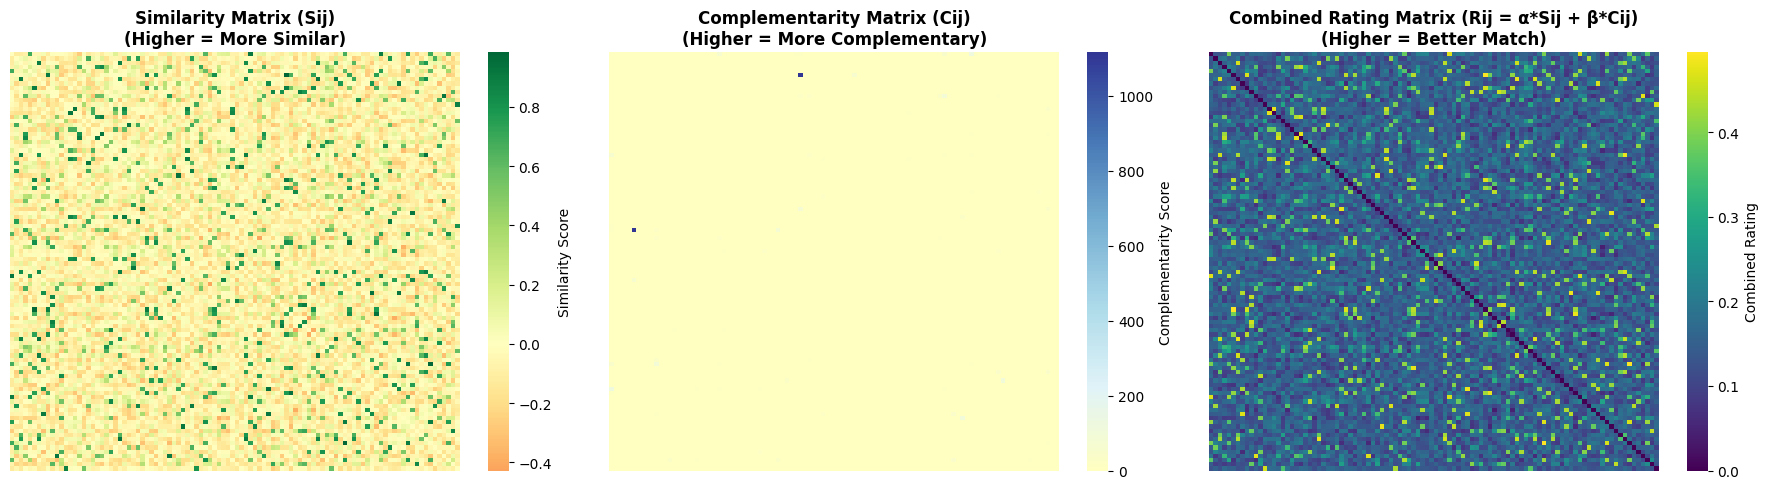

Visualization shows first 100 founders out of 1209 total
Full matrices: Sij shape=(1209, 1209), Cij shape=(1209, 1209), Rij shape=(1209, 1209)


In [ ]:
# Visualize Sij, Cij, and Rij matrices (sample for visualization - use subset for speed)
sample_size = min(100, n_founders)  # Show first 100 founders for visualization
sample_indices = np.arange(sample_size)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sij heatmap
sns.heatmap(Sij[np.ix_(sample_indices, sample_indices)],
            ax=axes[0], cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Similarity Score'},
            xticklabels=False, yticklabels=False)
axes[0].set_title('Similarity Matrix (Sij)\n(Higher = More Similar)', fontsize=12, fontweight='bold')

# Cij heatmap
sns.heatmap(Cij[np.ix_(sample_indices, sample_indices)],
            ax=axes[1], cmap='RdYlBu', center=0,
            cbar_kws={'label': 'Complementarity Score'},
            xticklabels=False, yticklabels=False)
axes[1].set_title('Complementarity Matrix (Cij)\n(Higher = More Complementary)', fontsize=12, fontweight='bold')

# Rij heatmap
sns.heatmap(Rij[np.ix_(sample_indices, sample_indices)],
            ax=axes[2], cmap='viridis',
            cbar_kws={'label': 'Combined Rating'},
            xticklabels=False, yticklabels=False)
axes[2].set_title('Combined Rating Matrix (Rij = α*Sij + β*Cij)\n(Higher = Better Match)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Visualization shows first {sample_size} founders out of {n_founders} total")
print(f"Full matrices: Sij shape={Sij.shape}, Cij shape={Cij.shape}, Rij shape={Rij.shape}")


## **Step 7: Creating Training/Validation/Test Split**

This cell prepares the data for machine learning by splitting it into train, validation, and test sets:

**Creating Pairwise Observations:**
- **`~np.eye(n_founders, dtype=bool)`**: Creates a boolean mask that excludes the diagonal
  - `np.eye()` creates an identity matrix (1s on diagonal, 0s elsewhere)
  - The `~` operator negates it, so diagonal becomes False, off-diagonal becomes True
- **`np.where(mask)`**: Returns indices where mask is True (i.e., all pairs where i ≠ j)
- **`user_indices, item_indices`**: In collaborative filtering terms:
  - `user_indices` = founder i (the "user" seeking a co-founder)
  - `item_indices` = founder j (the potential co-founder or "item" to recommend)
- **`ratings = Rij[user_indices, item_indices]`**: Extracts combined rating scores (from Rij) for all pairs

**Why this representation?**
- Each pair (i, j) represents one observation: "What is the combined similarity+complementarity score between founder i and founder j?"
- This format matches what matrix factorization models expect: (user_id, item_id, rating) tuples

**Splitting the Data:**
- **80% training**: Used to train the matrix factorization model
- **10% validation**: Used to tune hyperparameters and select the best model
- **10% test**: Used for final evaluation (unseen during training and tuning)

**`train_test_split()`**:
- Randomly splits indices while preserving the relationship between user_indices, item_indices, and ratings
- `random_state=42` ensures reproducible splits

This split allows us to train the model on some data, tune hyperparameters on validation data, and get an unbiased final evaluation on test data.


In [ ]:
# mask to exclude diagonal
mask = ~np.eye(n_founders, dtype=bool) # sets the diagonal to False cuz we don't want useri,useri recommendation (perfect match)
user_indices, item_indices = np.where(mask)
ratings = Rij[user_indices, item_indices]  # Use Rij (combined rating matrix)

print("Number of pairwise observations:", len(ratings))


Number of pairwise observations: 1460472


In [ ]:
# Train / validation / test split on pair indices
idx_all = np.arange(len(ratings)) #get an index for each user

# 20% test
train_idx, test_idx = train_test_split(
    idx_all, test_size=0.2, random_state=42
)
# 10% of remaining as validation
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.1, random_state=42
)

u_train = user_indices[train_idx]
i_train = item_indices[train_idx]
r_train = ratings[train_idx]

u_val   = user_indices[val_idx]
i_val   = item_indices[val_idx]
r_val   = ratings[val_idx]

u_test  = user_indices[test_idx]
i_test  = item_indices[test_idx]
r_test  = ratings[test_idx]

print("Train/Val/Test split sizes:", len(train_idx), len(val_idx), len(test_idx))


Train/Val/Test split sizes: 1051539 116838 292095


### **Step 7.1: scikit-learn wrapper for MF (for GridSearchCV)**

We wrap the SGD matrix factorization model in a scikit-learn compatible estimator so we can use `GridSearchCV` over k (n_factors) and λ (reg).


In [ ]:
class MFSGDRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_users, n_items, n_factors=20, lr=0.01, reg=0.02,
                 n_epochs=10, random_state=42, verbose=False):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.verbose = verbose
        self.model_ = None

    def fit(self, X, y):
        u_idx = X[:, 0].astype(int)
        i_idx = X[:, 1].astype(int)
        mf = MatrixFactorization(
            n_users=self.n_users,
            n_items=self.n_items,
            n_factors=self.n_factors,
            lr=self.lr,
            reg=self.reg,
            n_epochs=self.n_epochs,
            verbose=self.verbose,
            random_state=self.random_state
        )
        mf.fit(u_idx, i_idx, y)
        self.model_ = mf
        return self

    def predict(self, X):
        u_idx = X[:, 0].astype(int)
        i_idx = X[:, 1].astype(int)
        return np.array([self.model_.predict_single(u, i) for u, i in zip(u_idx, i_idx)])

    def score(self, X, y):
        preds = self.predict(X)
        rmse = np.sqrt(mean_squared_error(y, preds))
        return -rmse  # because GridSearchCV maximizes the score



## **Step 7.2: Matrix Factorization Model Definition**

This cell defines the `MatrixFactorization` class, which implements collaborative filtering using matrix factorization.

**What is Matrix Factorization?**
Matrix factorization decomposes the user-item rating matrix R (n_founders × n_founders) into two lower-dimensional matrices:
- **P** (n_founders × A): User/founder latent factors (embeddings)
- **Q** (n_founders × A): Item/founder latent factors (embeddings)

Where A is the number of latent factors (archetypes).

**Prediction Formula:**
```
rating_ij ≈ μ + b_u[i] + b_i[j] + P[i] · Q[j]
```

**Components:**
1. **μ (mu)**: Global bias (average rating across all pairs)
2. **b_u[i]**: User bias (how much founder i tends to rate others higher/lower than average)
3. **b_i[j]**: Item bias (how much founder j tends to be rated higher/lower than average)
4. **P[i] · Q[j]**: Dot product of latent factor vectors (captures interaction between founder i and founder j's characteristics)

**Key Methods:**

**`__init__()`**: Initializes hyperparameters
- `n_factors`: Number of latent dimensions (archetypes) - controls model complexity
- `lr`: Learning rate for gradient descent updates
- `reg`: Regularization strength (prevents overfitting by penalizing large parameter values)
- `n_epochs`: Number of training iterations over the dataset

**`fit()`**: Trains the model using stochastic gradient descent
- Initializes P, Q, b_u, b_i with small random values
- For each epoch, randomly permutes training examples
- For each (user, item, rating) triple:
  - Computes prediction and error
  - Updates parameters using gradient descent with regularization
- Tracks validation RMSE and keeps best parameters (early stopping)

**`predict_single()`**: Predicts similarity score for a single (founder i, founder j) pair

**`rmse()`**: Computes Root Mean Square Error for evaluation

This model learns to represent founders in a low-dimensional space where similar founders are close together, enabling effective recommendations.


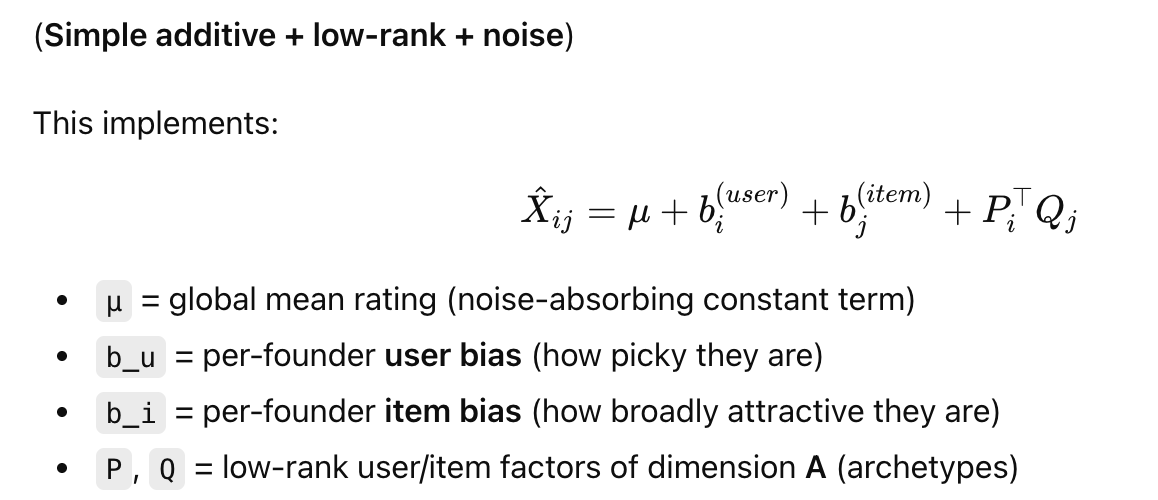

In [ ]:
class MatrixFactorization:
    """
    Standard explicit-feedback matrix factorization with user/item biases:
    rating_ij ~ mu + b_u[i] + b_i[j] + P[i]·Q[j]

    This corresponds to:
        Simple Additive (mu + b_u + b_i) + Low-Rank (P Q^T) + Noise
    """
    def __init__(self, n_users, n_items, n_factors=20,
                 lr=0.01, reg=0.02, n_epochs=10, verbose=True,
                 random_state=42):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.random_state = random_state

    def fit(self, user_idx, item_idx, ratings,
            val_user_idx=None, val_item_idx=None, val_ratings=None):
        rng = np.random.default_rng(self.random_state)
        n_obs = len(ratings)

        # Initialize parameters
        self.P = 0.1 * rng.standard_normal((self.n_users, self.n_factors))
        self.Q = 0.1 * rng.standard_normal((self.n_items, self.n_factors))
        self.b_u = np.zeros(self.n_users)
        self.b_i = np.zeros(self.n_items)
        self.mu = ratings.mean()

        best_val_rmse = np.inf
        best_params = None

        for epoch in range(self.n_epochs):
            perm = rng.permutation(n_obs)
            for idx in perm:
                u = user_idx[idx]
                i = item_idx[idx]
                r = ratings[idx]

                # prediction and error
                pred = self.mu + self.b_u[u] + self.b_i[i] + np.dot(self.P[u], self.Q[i])
                err = r - pred

                # gradient updates
                self.b_u[u] += self.lr * (err - self.reg * self.b_u[u])
                self.b_i[i] += self.lr * (err - self.reg * self.b_i[i])

                Pu = self.P[u].copy()
                Qi = self.Q[i].copy()

                self.P[u] += self.lr * (err * Qi - self.reg * Pu)
                self.Q[i] += self.lr * (err * Pu - self.reg * Qi)

            # metrics
            train_rmse = self.rmse(user_idx, item_idx, ratings)
            if val_ratings is not None:
                val_rmse = self.rmse(val_user_idx, val_item_idx, val_ratings)
                if self.verbose:
                    print(f"Epoch {epoch+1}/{self.n_epochs} "
                          f"train_rmse={train_rmse:.4f}  val_rmse={val_rmse:.4f}")
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_params = (
                        self.P.copy(), self.Q.copy(),
                        self.b_u.copy(), self.b_i.copy(), self.mu
                    )
            else:
                if self.verbose:
                    print(f"Epoch {epoch+1}/{self.n_epochs} train_rmse={train_rmse:.4f}")

        # restore best validation parameters
        if val_ratings is not None and best_params is not None:
            self.P, self.Q, self.b_u, self.b_i, self.mu = best_params

        return self

    def predict_single(self, u, i):
        return self.mu + self.b_u[u] + self.b_i[i] + np.dot(self.P[u], self.Q[i])

    def rmse(self, u_idx, i_idx, ratings):
        preds = self.mu + self.b_u[u_idx] + self.b_i[i_idx] + \
                np.sum(self.P[u_idx] * self.Q[i_idx], axis=1)
        return np.sqrt(np.mean((ratings - preds) ** 2))


## **Step 8: Hyperparameter Tuning with Grid Search CV**

This step searches for the best combination of:
- **k (n_factors / archetypes)**
- **λ (reg, L2 regularization strength for SGD)**

**What we will grid-search:**
1. **`latent_dims`**: candidate archetype counts (k values)
2. **`reg_grid`**: candidate L2 regularization strengths (λ values)

**Process:**
- For every (k, λ) pair, fit the matrix factorization model on the training set
- Evaluate on the validation set (used for model selection)
- Also record test RMSE for reference (not used to pick the model)
- Pick the model with the lowest validation RMSE

**Why use λ?**
- Regularization controls overfitting by shrinking parameters (P, Q, b_u, b_i)
- A grid search lets us balance bias/variance and pick a λ that generalizes best

The selected model (best k, best λ) will be used for recommendations and downstream interpretation.


In [ ]:
latent_dims = [4, 8, 12, 16, 24]
reg_grid = [0.005, 0.01, 0.02, 0.05]

# Build X matrices for GridSearchCV (columns: user_idx, item_idx)
X_train = np.column_stack([u_train, i_train])
X_val   = np.column_stack([u_val, i_val])
X_test  = np.column_stack([u_test, i_test])

# RMSE scorer (negative for maximization)
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse_scorer, greater_is_better=False)

estimator = MFSGDRegressor(
    n_users=n_founders,
    n_items=n_founders,
    lr=0.01,
    n_epochs=10,
    random_state=42,
    verbose=False
)

param_grid = {
    'n_factors': latent_dims,
    'reg': reg_grid
}

print("Running GridSearchCV over k and reg ...")
grid = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, r_train)
print("Grid search done.")

# Extract best model and metrics
best_est = grid.best_estimator_
best_model = best_est.model_
best_A = best_est.n_factors
best_reg = best_est.reg

# Compute RMSE on train/val/test
best_train_rmse = rmse_scorer(r_train, best_est.predict(X_train))
best_val_rmse = rmse_scorer(r_val, best_est.predict(X_val))
best_test_rmse = rmse_scorer(r_test, best_est.predict(X_test))

# Collect results DataFrame
results_df = pd.DataFrame(grid.cv_results_)
results_df['rmse'] = -results_df['mean_test_score']  # because scorer is negative
results = list(zip(results_df['param_n_factors'], results_df['param_reg'], results_df['rmse']))

print(f"\nBest model: k = {best_A}, reg = {best_reg}")
print(f"Best RMSEs -> train: {best_train_rmse:.4f}, val: {best_val_rmse:.4f}, test: {best_test_rmse:.4f}")


Running GridSearchCV over k and reg ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Grid search done.

Best model: k = 24, reg = 0.02
Best RMSEs -> train: 0.0789, val: 0.0796, test: 0.0790


## **Step 8.1: Visualizing RMSE vs K (Number of Archetypes) Tradeoff**

This visualization shows the relationship between the number of latent factors (archetypes) and model performance:

- **X-axis**: Number of archetypes (k values: 4, 8, 12, 16, 24)
- **Y-axis**: RMSE (Root Mean Squared Error)
- **Two lines**: Validation RMSE and Test RMSE

This helps us understand:
1. **Bias-Variance Tradeoff**: Fewer archetypes may underfit (high bias), while more archetypes may overfit (high variance)
2. **Optimal K**: The point where validation RMSE is minimized indicates the best number of archetypes
3. **Generalization**: The gap between validation and test RMSE indicates how well the model generalizes

The plot helps identify the sweet spot where we have enough complexity to capture patterns without overfitting.


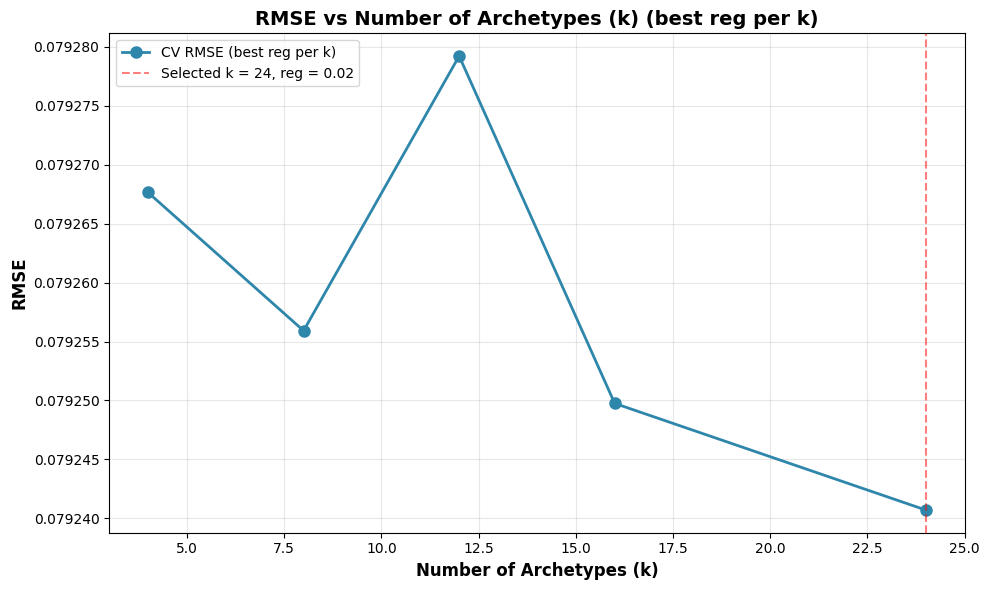


Selected model -> k = 24, reg = 0.02
RMSEs -> train: 0.0789, val: 0.0796, test: 0.0790


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# results_df is created in the GridSearchCV cell from grid.cv_results_
# For plotting, take the best reg per k (lowest rmse)
best_per_k = results_df.loc[results_df.groupby('param_n_factors')['rmse'].idxmin()].sort_values('param_n_factors')

plt.figure(figsize=(10, 6))
plt.plot(best_per_k['param_n_factors'], best_per_k['rmse'], marker='o', linewidth=2, markersize=8, label='CV RMSE (best reg per k)', color='#2E86AB')

plt.axvline(x=best_A, color='red', linestyle='--', alpha=0.5, label=f'Selected k = {best_A}, reg = {best_reg}')

plt.xlabel('Number of Archetypes (k)', fontsize=12, fontweight='bold')
plt.ylabel('RMSE', fontsize=12, fontweight='bold')
plt.title('RMSE vs Number of Archetypes (k) (best reg per k)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nSelected model -> k = {best_A}, reg = {best_reg}")
print(f"RMSEs -> train: {best_train_rmse:.4f}, val: {best_val_rmse:.4f}, test: {best_test_rmse:.4f}")


In [ ]:
# ---- Step 8.2: Final performance metrics for the selected model ----
print("Best hyperparameters from grid search:")
print(f"  k (archetypes): {best_A}")
print(f"  reg (lambda):   {best_reg}")
print("\nPerformance (RMSE):")
print(f"  Train: {best_train_rmse:.4f}")
print(f"  Val:   {best_val_rmse:.4f}")
print(f"  Test:  {best_test_rmse:.4f}")


Best hyperparameters from grid search:
  k (archetypes): 24
  reg (lambda):   0.02

Performance (RMSE):
  Train: 0.0789
  Val:   0.0796
  Test:  0.0790


## **Step 9: Recommendation Function**

This cell defines a function to generate top-k co-founder recommendations for any given founder:

**`recommend_top_k_for_founder()` Function:**

**Parameters:**
- `model`: The trained MatrixFactorization model
- `founder_index`: The index (0 to n_founders-1) of the founder seeking recommendations
- `k`: Number of top recommendations to return (default: 3)

**Process:**
1. **Generate predictions**: For the given founder, predicts similarity scores with all other founders
   - Uses list comprehension with `model.predict_single(founder_index, j)` for all j
   - Creates array of predicted match scores

2. **Exclude self**: Sets `scores[founder_index] = -np.inf` so the founder won't be recommended to themselves

3. **Select top-k**:
   - `np.argsort(scores)[::-1]`: Gets indices sorted by score in descending order
   - `[:k]`: Takes top k indices

4. **Format results**: Creates a DataFrame with:
   - Founder ID
   - Preferred role
   - Industry
   - Years of experience
   - Technical background (is_technical)
   - Problem space
   - Predicted match score

**Why this approach?**
- Uses the trained model to predict compatibility scores
- Ranks all potential co-founders and returns the most compatible ones
- Provides interpretable output with relevant founder information

This function enables generating personalized recommendations for any founder in the dataset.


In [ ]:
founder_ids = df[FOUNDER_ID_COL].tolist()

def recommend_top_k_for_founder(model, founder_index, k=3):
    """
    founder_index: integer index into df (0 .. n_founders-1)
    k: number of recommended cofounders
    """
    n = model.n_users
    scores = np.array([model.predict_single(founder_index, j) for j in range(n)])
    # Do not recommend yourself
    scores[founder_index] = -np.inf

    top_idx = np.argsort(scores)[::-1][:k]
    top_scores = scores[top_idx]

    recs = df.loc[top_idx, [
        FOUNDER_ID_COL,
        'preferred_role',
        'industry',
        'years_of_experience',
        'is_technical',
        'problem_space'
    ]].copy()
    recs['predicted_match_score'] = top_scores

    return recs.reset_index(drop=True)


## **Step 10: Generating Recommendations for All Founders**

This cell generates and stores recommendations for every founder in the dataset:

**Process:**
1. **`founder_ids = df[FOUNDER_ID_COL].tolist()`**: Extracts list of all founder IDs from the dataset

2. **Loop through all founders**: For each founder (indexed 0 to n_founders-1):
   - Calls `recommend_top_k_for_founder()` with the best trained model
   - Requests top 5 recommendations (k=5)
   - Stores results in a dictionary keyed by founder ID

3. **Storage**: `all_recommendations` dictionary maps:
   - Key: founder_id (unique identifier)
   - Value: DataFrame with top 5 recommended co-founders and their details

**Example Usage:**
- After running this cell, you can access recommendations for any founder
- Example: `all_recommendations[some_id]` shows the top 5 co-founder matches for that founder

**Use Cases:**
- Generate comprehensive recommendation sets for all founders
- Enable quick lookup of recommendations by founder ID
- Support batch processing or API endpoints for a recommendation system

This completes the collaborative filtering pipeline: from raw data → feature engineering → similarity computation → matrix factorization → personalized recommendations!


Build observed pairs & train/val/test split

We treat each ordered pair (i, j), i ≠ j, as an “observation” of a rating.

## **Step 11: Archetype Interpretation**

This section analyzes the learned archetypes to understand what characteristics they represent. By examining the average weights of each archetype across different feature categories (industry, preferred_role, tech_stack), we can interpret what each archetype captures.

**How to interpret the heatmaps:**
- Each row represents an archetype (latent factor)
- Each column represents a category value (e.g., "Fintech" industry, "CEO" role)
- The color intensity shows the average weight: darker colors indicate stronger association
- If all users with industry="Fintech" have high weights for Archetype 1, then Archetype 1 is related to Fintech

This analysis helps us understand:
1. What each archetype represents in terms of founder characteristics
2. Which industries, roles, or tech stacks are associated with each archetype
3. How the collaborative filtering model groups similar founders


In [ ]:
# Extract archetype weights (Q matrix represents item factors - how each founder relates to each archetype)
# Since users and items are both founders, we can use either P or Q. Using Q for interpretation.
archetype_weights = best_model.Q  # Shape: (n_founders, n_archetypes)

# Create a DataFrame with founder information and archetype weights
founder_archetype_df = df[[FOUNDER_ID_COL, 'industry', 'preferred_role', 'tech_stack']].copy()

# Add archetype weight columns
for arch_idx in range(best_A):
    founder_archetype_df[f'Archetype_{arch_idx+1}'] = archetype_weights[:, arch_idx]

print(f"Archetype weights matrix shape: {archetype_weights.shape}")
print(f"Number of archetypes: {best_A}")
print(f"\nFirst few rows of founder-archetype data:")
founder_archetype_df.head()


Archetype weights matrix shape: (1209, 24)
Number of archetypes: 24

First few rows of founder-archetype data:


,founder_id,industry,preferred_role,tech_stack,Archetype_1,Archetype_2,Archetype_3,Archetype_4,Archetype_5,Archetype_6,...,Archetype_15,Archetype_16,Archetype_17,Archetype_18,Archetype_19,Archetype_20,Archetype_21,Archetype_22,Archetype_23,Archetype_24
0,0a5e3dd8489fe67485ddb7d6adb26ebd,Other,COO,"[Swift, Node.js]",-0.016676,-0.004912,-0.007543,-0.032711,0.004921,0.005443,...,-0.025397,-0.016267,0.002327,0.004099,0.014979,0.017346,-0.008760,0.004934,-0.006517,0.006226
1,10a8c197447a3991d64136b315d6e87e,Gaming / Entertainment,CEO,"[Unity, C#, JavaScript, Webflow]",-0.003808,-0.001773,-0.003348,-0.026016,0.013197,0.006085,...,0.023033,0.009428,0.035903,0.004561,0.007371,-0.015798,0.000064,-0.007597,0.018289,0.007641
2,048dd37565ad9cbc24c163ffedffbf58,Consumer / Social,CEO,"[React, Node.js, Firebase]",0.002906,0.005982,0.005914,-0.008308,-0.007408,0.021339,...,0.000252,-0.019589,0.008244,0.003287,-0.007870,-0.001540,0.008130,0.018967,-0.005237,0.014824
3,024610702baf540af5637873cd1534e9,Fintech,COO,"[Figma, Swift, Notion, AWS]",-0.005136,0.025386,-0.009860,-0.024166,-0.006194,-0.002874,...,0.002781,-0.002413,0.029494,0.018381,0.016697,0.007328,0.020797,-0.015509,0.001592,0.029412
4,2057ea510896a025db5790675c90b7d6,Other,CTO,"[AWS, Django, Swift, Docker]",0.006672,0.002809,0.012067,-0.002162,0.013477,0.001957,...,-0.024762,-0.015194,-0.015909,-0.010417,-0.009474,0.022522,-0.003315,0.015943,-0.014200,-0.004454


### **Step 11.1: Archetype Weights by Industry**

This heatmap shows the average weight of each archetype for founders in different industries. This helps identify which archetypes are associated with specific industries.


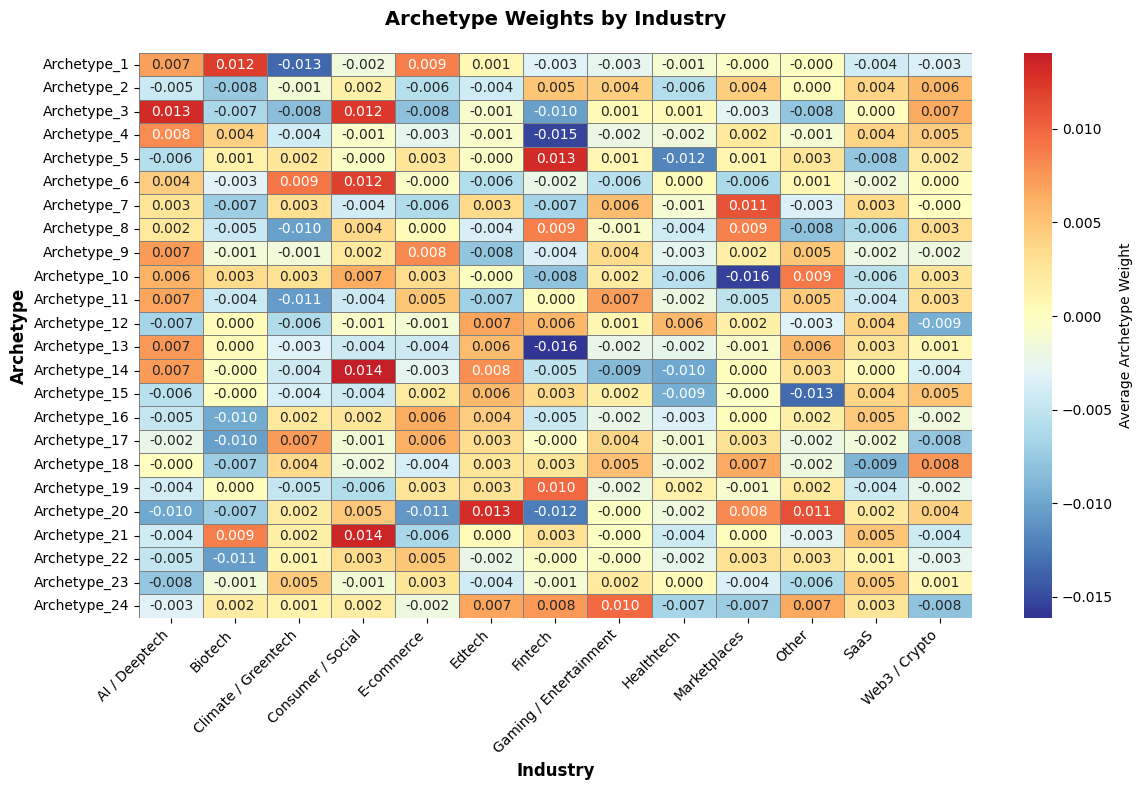

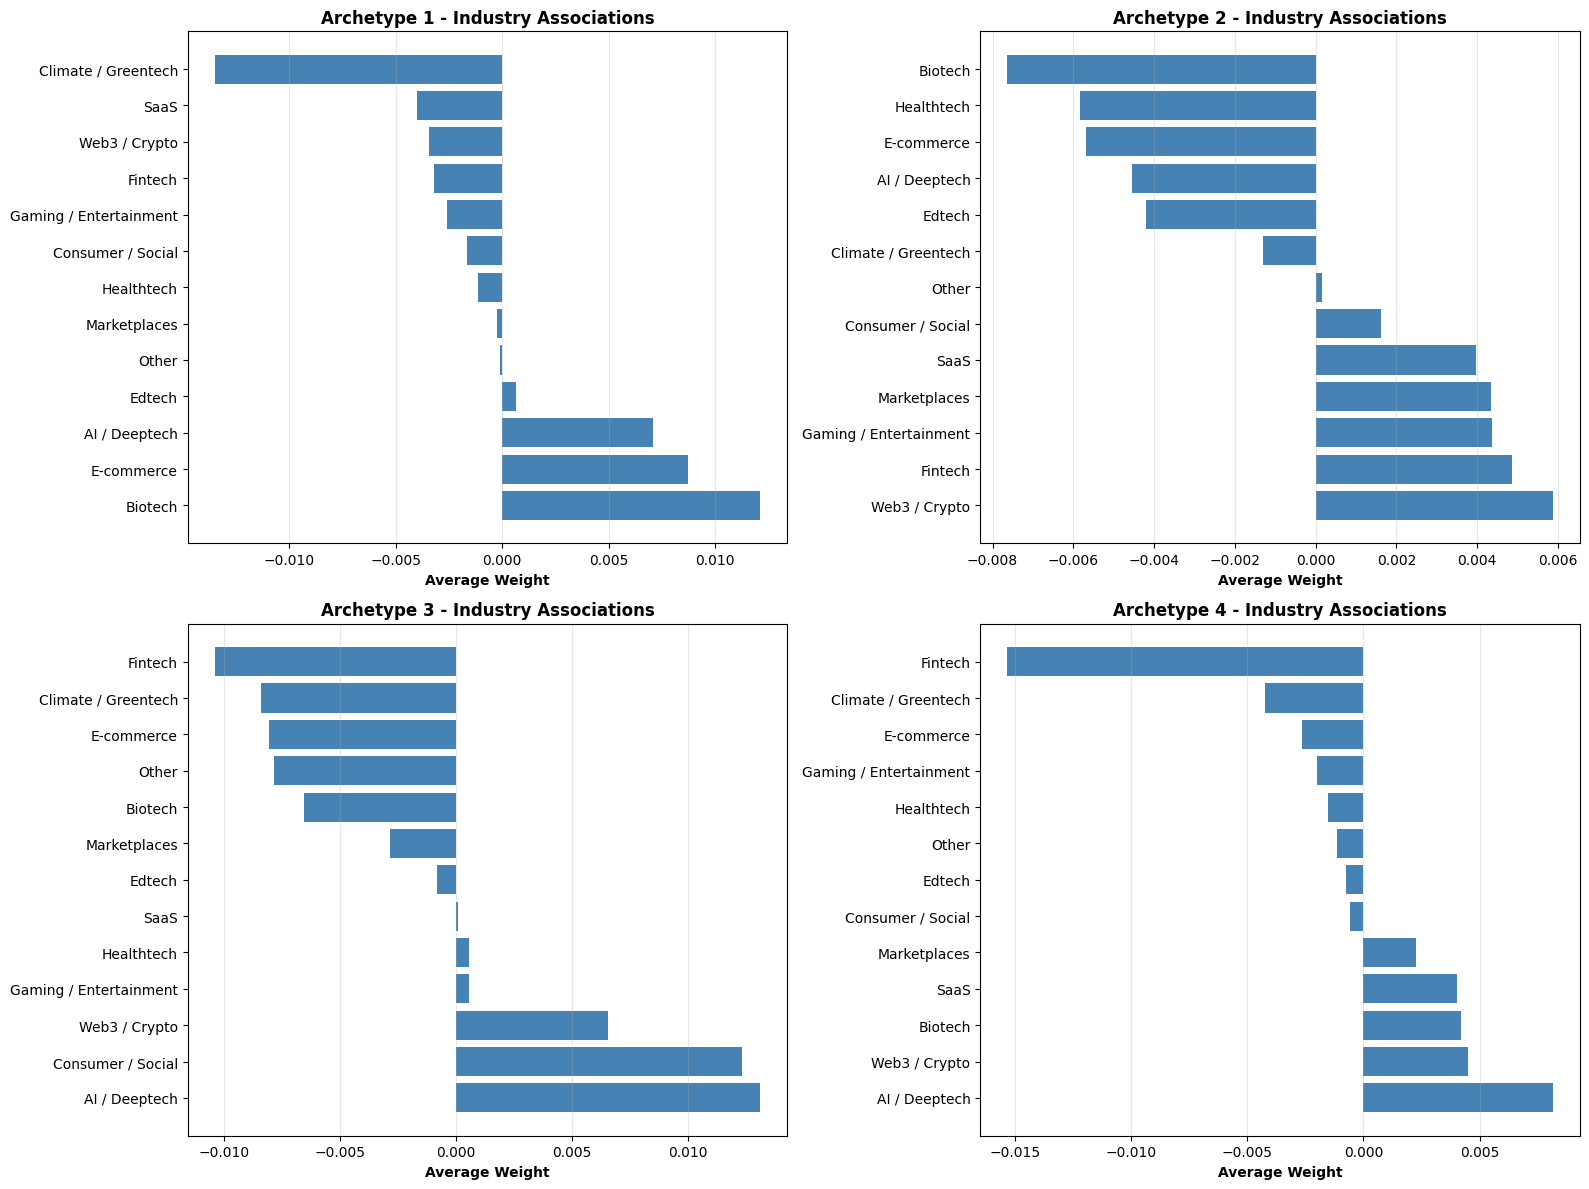

In [ ]:
# Calculate average archetype weights by industry
industry_archetype = founder_archetype_df.groupby('industry')[[f'Archetype_{i+1}' for i in range(best_A)]].mean()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(industry_archetype.T,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0,
            cbar_kws={'label': 'Average Archetype Weight'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Archetype Weights by Industry', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Industry', fontsize=12, fontweight='bold')
plt.ylabel('Archetype', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Also create a bar plot for better visualization of top associations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for arch_idx in range(min(best_A, 4)):  # Show first 4 archetypes
    arch_data = industry_archetype[f'Archetype_{arch_idx+1}'].sort_values(ascending=False)
    axes[arch_idx].barh(range(len(arch_data)), arch_data.values, color='steelblue')
    axes[arch_idx].set_yticks(range(len(arch_data)))
    axes[arch_idx].set_yticklabels(arch_data.index)
    axes[arch_idx].set_xlabel('Average Weight', fontweight='bold')
    axes[arch_idx].set_title(f'Archetype {arch_idx+1} - Industry Associations', fontweight='bold')
    axes[arch_idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### **Step 11.2: Archetype Weights by Preferred Role**

This heatmap shows the average weight of each archetype for founders with different preferred roles (CEO, CTO, COO, CPO).


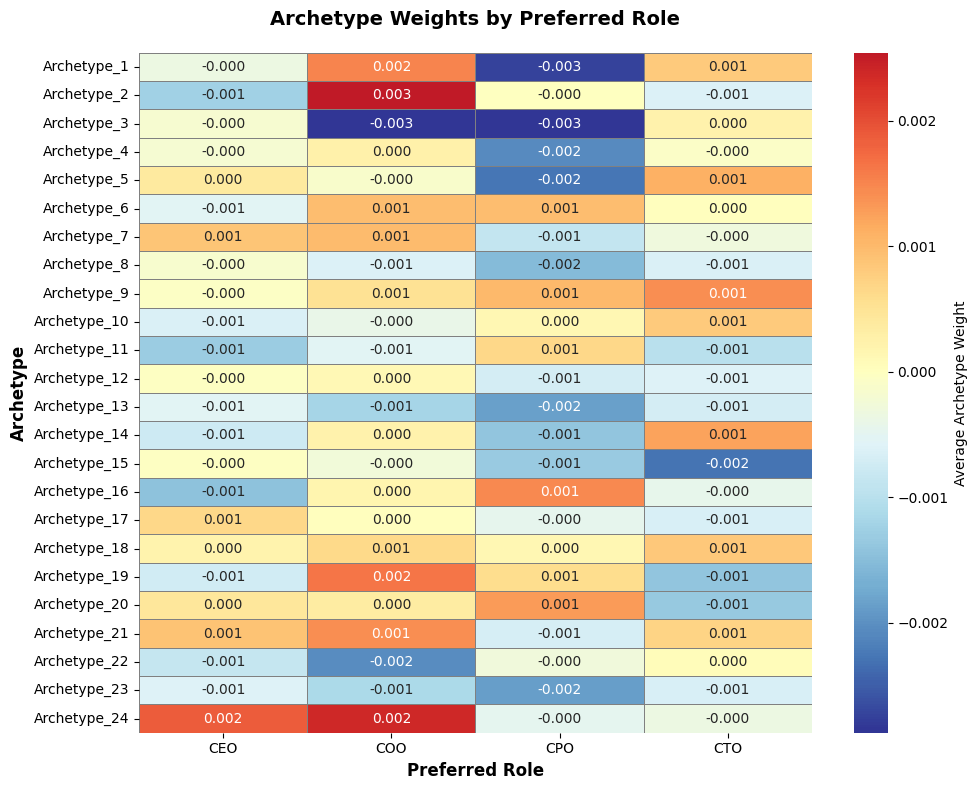

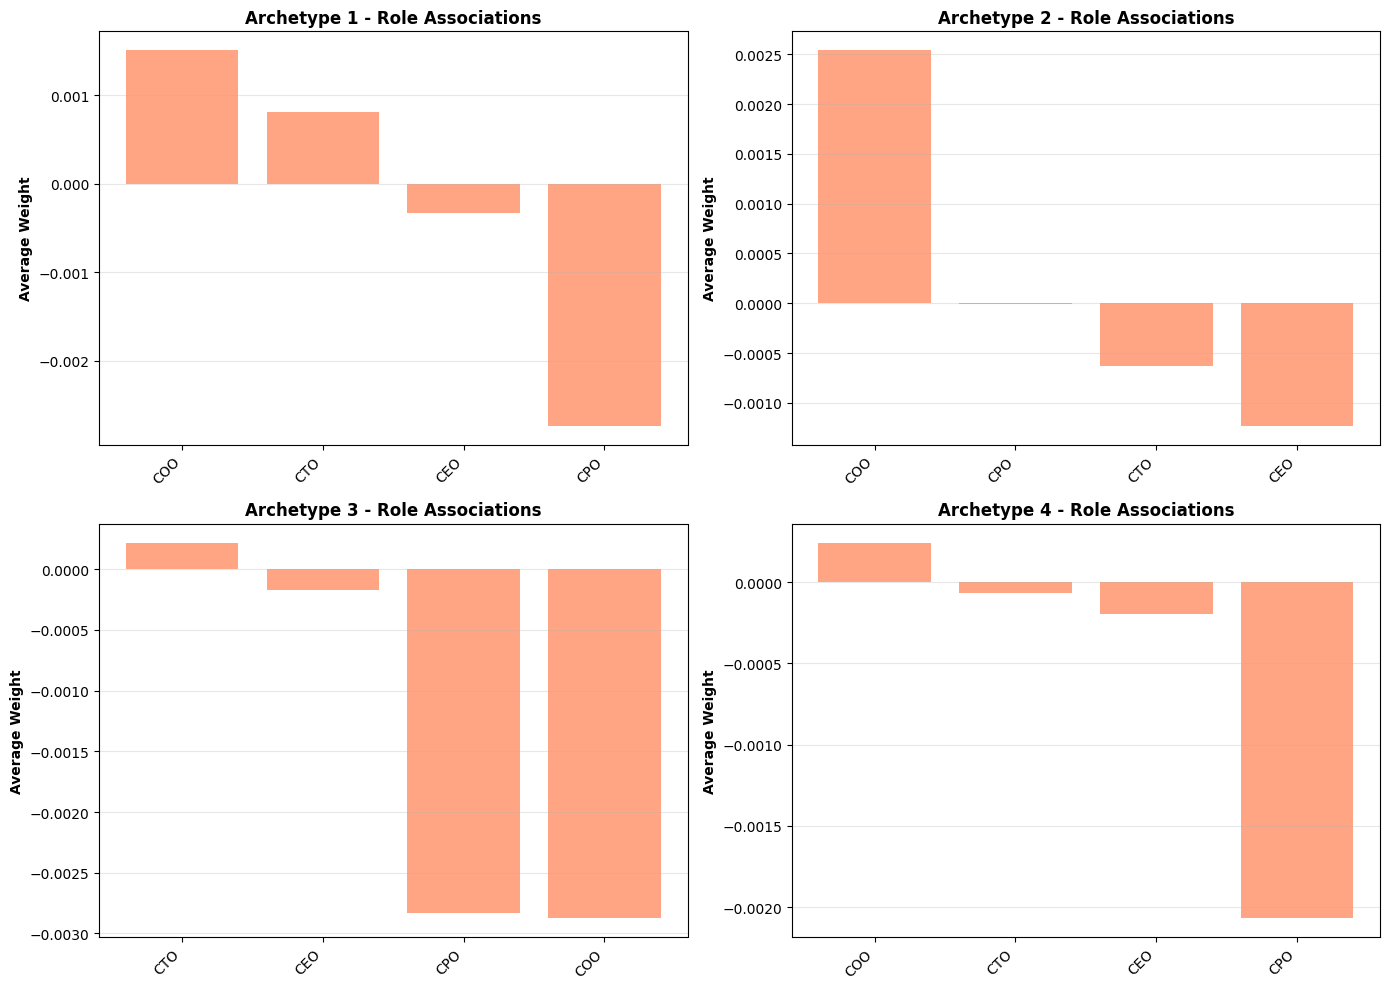

In [ ]:
# Calculate average archetype weights by preferred_role
role_archetype = founder_archetype_df.groupby('preferred_role')[[f'Archetype_{i+1}' for i in range(best_A)]].mean()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(role_archetype.T,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0,
            cbar_kws={'label': 'Average Archetype Weight'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Archetype Weights by Preferred Role', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Preferred Role', fontsize=12, fontweight='bold')
plt.ylabel('Archetype', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bar plot for role associations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for arch_idx in range(min(best_A, 4)):  # Show first 4 archetypes
    arch_data = role_archetype[f'Archetype_{arch_idx+1}'].sort_values(ascending=False)
    axes[arch_idx].bar(range(len(arch_data)), arch_data.values, color='coral', alpha=0.7)
    axes[arch_idx].set_xticks(range(len(arch_data)))
    axes[arch_idx].set_xticklabels(arch_data.index, rotation=45, ha='right')
    axes[arch_idx].set_ylabel('Average Weight', fontweight='bold')
    axes[arch_idx].set_title(f'Archetype {arch_idx+1} - Role Associations', fontweight='bold')
    axes[arch_idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### **Step 11.3: Archetype Weights by Tech Stack**

This heatmap shows the average weight of each archetype for founders using different technologies. Since tech_stack is a multi-label column (founders can have multiple technologies), we analyze each technology separately.


### **Step 11.4: Top Feature Elements per Archetype**

For each archetype, list the feature elements (e.g., `roles__CEO`, `industry_Fintech`, `tech_stack__Python`) that have the strongest association with that archetype. We measure association via absolute correlation between the archetype weights and standardized feature columns, then report the top contributors.


In [ ]:
# Standardize all features for fair comparison across scales
all_features_z = (all_features - all_features.mean()) / (all_features.std(ddof=0) + 1e-8)
all_features_z = all_features_z.fillna(0.0)

# Archetype weights (using Q)
archetype_scores = pd.DataFrame(best_model.Q, columns=[f'Archetype_{i+1}' for i in range(best_A)])

def top_feature_elements_per_archetype(features_df, archetype_df, top_n=10):
    results = {}
    for arch_col in archetype_df.columns:
        # correlation between feature column and archetype weight
        corrs = features_df.apply(lambda col: np.corrcoef(col, archetype_df[arch_col])[0, 1])
        corrs = corrs.dropna()
        corrs_abs = corrs.abs().sort_values(ascending=False).head(top_n)
        results[arch_col] = corrs_abs
    return results

TOP_N = 10
arch_top_features = top_feature_elements_per_archetype(all_features_z, archetype_scores, top_n=TOP_N)

for arch, series in arch_top_features.items():
    print(f"\n{arch}: top {TOP_N} feature elements (by |correlation| with archetype weight)")
    for feat, score in series.items():
        print(f"  {feat}: {score:.3f}")



Archetype_1: top 10 feature elements (by |correlation| with archetype weight)
  industry_Climate / Greentech: 0.240
  risk_tolerance: 0.228
  industry_Biotech: 0.204
  responsiveness_score: 0.187
  industry_E-commerce: 0.150
  industry_AI / Deeptech: 0.137
  tech_stack__TensorFlow: 0.125
  collaboration_openness_score: 0.117
  communication_intensity_score: 0.102
  weaknesses__Lack of focus: 0.085

Archetype_2: top 10 feature elements (by |correlation| with archetype weight)
  industry_Biotech: 0.131
  responsiveness_score: 0.123
  industry_Web3 / Crypto: 0.108
  industry_E-commerce: 0.098
  industry_Fintech: 0.097
  collaboration_openness_score: 0.096
  industry_Healthtech: 0.092
  weaknesses__Weak in hiring: 0.090
  industry_Marketplaces: 0.090
  industry_Gaming / Entertainment: 0.088

Archetype_3: top 10 feature elements (by |correlation| with archetype weight)
  industry_AI / Deeptech: 0.277
  industry_Consumer / Social: 0.222
  tech_stack__TensorFlow: 0.195
  industry_Fintech: 0.

### **Step 11.5: Archetype Interpretation - What Each Archetype Represents**

This section provides a human-readable interpretation of each archetype based on the feature weights. Each archetype can be understood as a latent dimension that captures specific founder characteristics, industries, skills, or behavioral patterns.


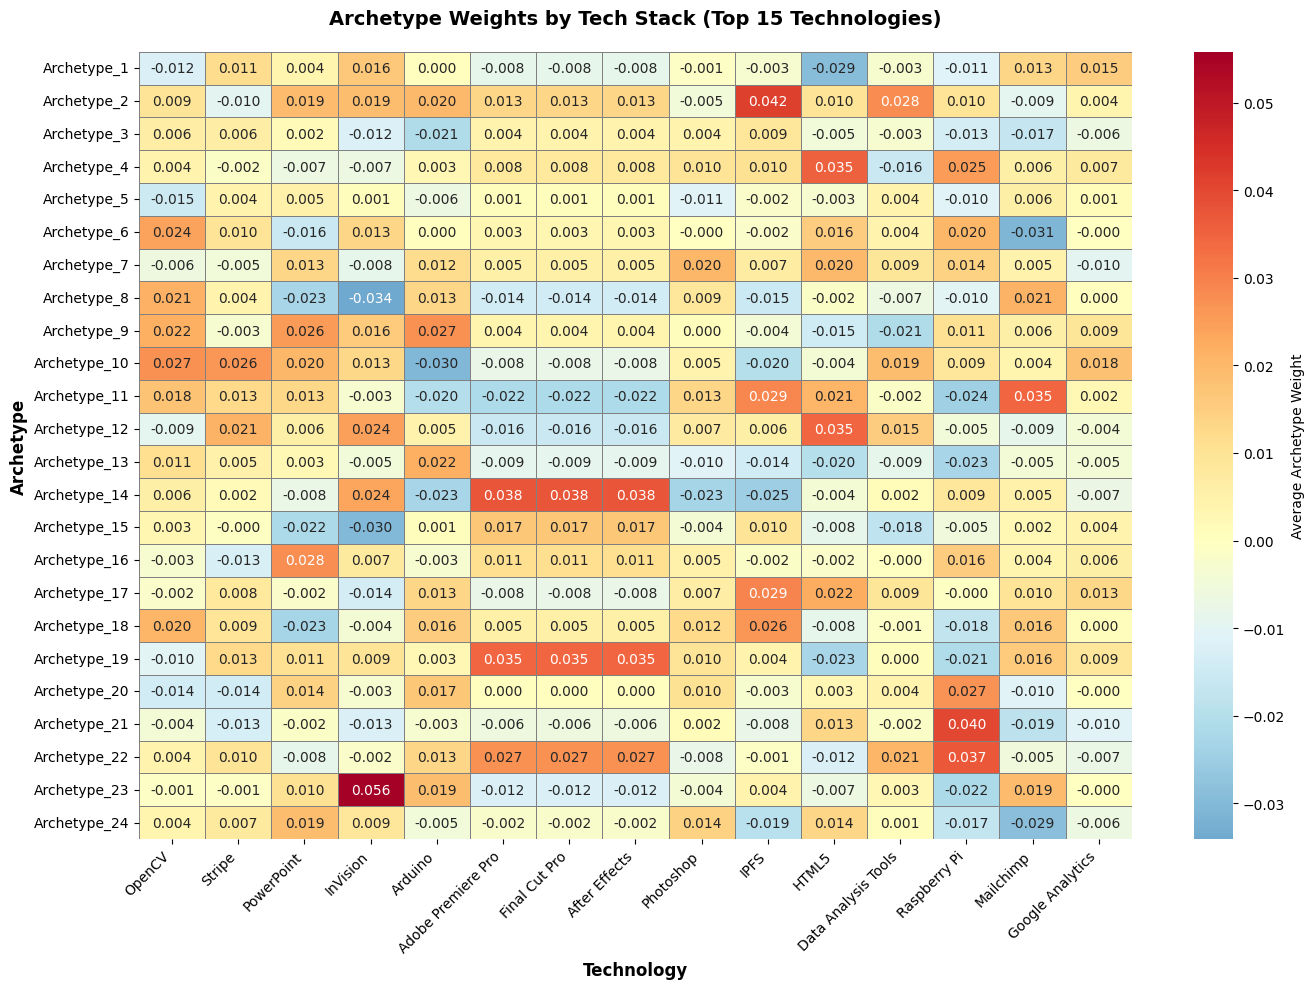

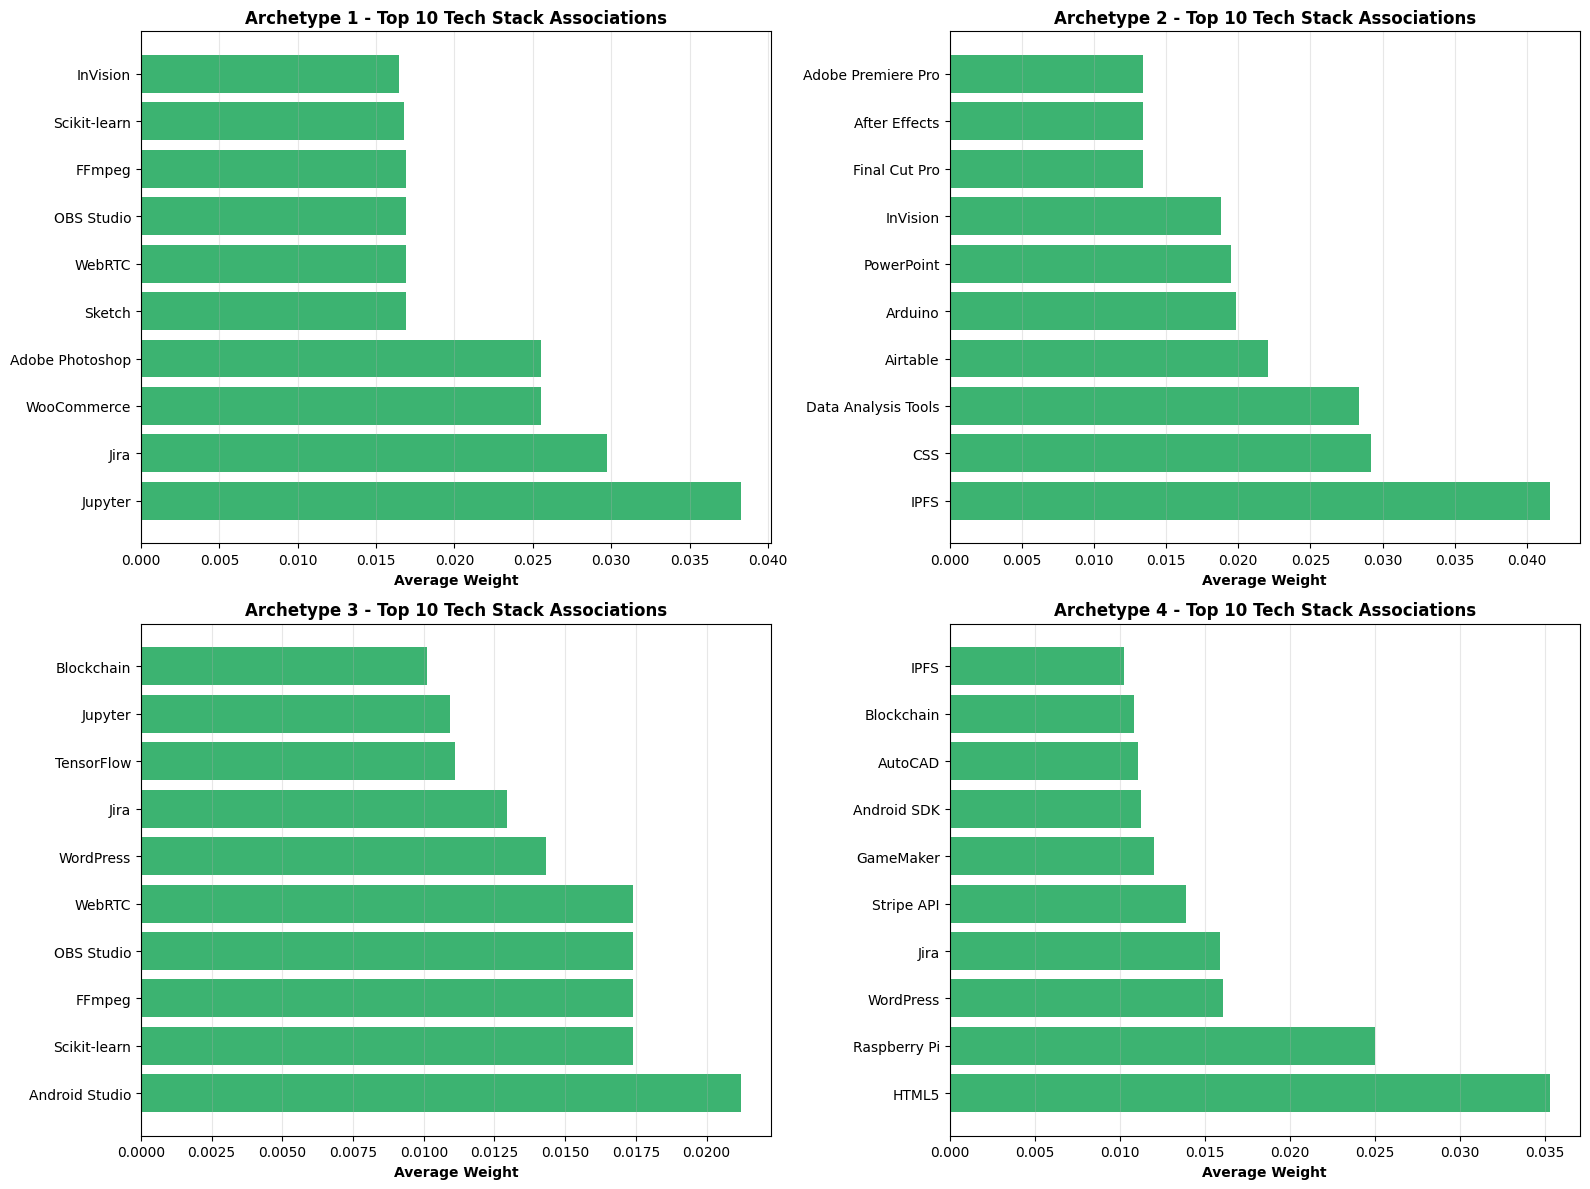


Total number of unique technologies: 75
Showing top 15 technologies in heatmap


In [ ]:
# Parse tech_stack and create a mapping
# tech_stack is stored as a list, so we need to expand it
tech_archetype_data = []

for idx, row in founder_archetype_df.iterrows():
    tech_list = row['tech_stack'] if isinstance(row['tech_stack'], list) else ast.literal_eval(str(row['tech_stack']))
    if tech_list:  # Only process if tech_stack is not empty
        for tech in tech_list:
            tech_archetype_data.append({
                'tech': tech,
                **{f'Archetype_{i+1}': row[f'Archetype_{i+1}'] for i in range(best_A)}
            })

tech_archetype_df = pd.DataFrame(tech_archetype_data)

# Calculate average archetype weights by tech stack
tech_archetype = tech_archetype_df.groupby('tech')[[f'Archetype_{i+1}' for i in range(best_A)]].mean()

# Sort by total weight across all archetypes to show most important tech stacks
tech_archetype['total_weight'] = tech_archetype.sum(axis=1)
tech_archetype = tech_archetype.sort_values('total_weight', ascending=False).drop('total_weight', axis=1)

# Show top 15 tech stacks to keep visualization readable
top_techs = tech_archetype.head(15)

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(top_techs.T,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0,
            cbar_kws={'label': 'Average Archetype Weight'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Archetype Weights by Tech Stack (Top 15 Technologies)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Technology', fontsize=12, fontweight='bold')
plt.ylabel('Archetype', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bar plot for tech stack associations (showing top 10 techs per archetype)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for arch_idx in range(min(best_A, 4)):  # Show first 4 archetypes
    arch_data = tech_archetype[f'Archetype_{arch_idx+1}'].sort_values(ascending=False).head(10)
    axes[arch_idx].barh(range(len(arch_data)), arch_data.values, color='mediumseagreen')
    axes[arch_idx].set_yticks(range(len(arch_data)))
    axes[arch_idx].set_yticklabels(arch_data.index)
    axes[arch_idx].set_xlabel('Average Weight', fontweight='bold')
    axes[arch_idx].set_title(f'Archetype {arch_idx+1} - Top 10 Tech Stack Associations', fontweight='bold')
    axes[arch_idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal number of unique technologies: {len(tech_archetype)}")
print(f"Showing top 15 technologies in heatmap")


## Loop over the founders and store their recommendations

### Archetype Interpretation

The matrix factorization model learned 24 latent archetypes that capture distinct patterns in founder characteristics. By analyzing the correlation between each archetype's weights and the original features, we can interpret what each archetype represents. Below are interpretations of the key archetypes based on their strongest feature associations:

**Archetype 1** is primarily **a measure of risk-taking propensity** - founders with higher weights on this archetype tend to have higher risk tolerance (correlation: 0.228). This archetype is strongly associated with founders in Climate/Greentech (0.240) and Biotech (0.204) industries, who also tend to have higher responsiveness scores (0.187) and use TensorFlow in their tech stack (0.125). This suggests a profile of environmentally-conscious, risk-tolerant founders working in emerging technology sectors.

**Archetype 2** represents founders with moderate responsiveness scores (0.123) and collaboration openness (0.096), but without strong industry specialization. This archetype shows relatively balanced associations across multiple industries (Biotech, Web3/Crypto, E-commerce, Fintech, Healthtech, Marketplaces, Gaming/Entertainment), suggesting it captures generalist founders who may struggle with hiring (weakness correlation: 0.090).

**Archetype 3** is a metric for **founders who know TensorFlow (0.195) and Solidity (0.112)** and work primarily in **AI/Deeptech (0.277) and Consumer/Social (0.222)** industries. This archetype also shows moderate risk tolerance (0.133) and strong associations with Fintech (0.175), Climate/Greentech (0.141), and Web3/Crypto (0.126), representing tech-savvy founders in cutting-edge sectors.

**Archetype 4** is strongly associated with **Fintech founders (0.292)** who also work in **AI/Deeptech (0.180)**. This archetype represents founders with **high responsiveness scores (0.172)** who know **TensorFlow (0.109), Webflow (0.083), and Tableau (0.077)**, suggesting a profile of data-driven, responsive founders in financial technology with strong analytics capabilities.

**Archetype 5** is a metric for **CPO (Chief Product Officer) founders (roles: 0.070, preferred_role: 0.067)** working in **Fintech (0.254) and Healthtech (0.207)** industries, with some presence in SaaS (0.140) and AI/Deeptech (0.126). This archetype is associated with founders who know TensorFlow (0.073) and tend to have weaknesses including being overly perfectionist (0.072), struggling with prioritization (0.063), and being weak in sales (0.059) - characteristics typical of product-focused founders.

These interpretations demonstrate that the archetypes capture meaningful, interpretable dimensions of founder profiles, combining behavioral traits (risk tolerance, responsiveness), industry affiliations, technical skills, and role characteristics. This interpretability is crucial for understanding why certain founder pairs are recommended and for building trust in the recommendation system.


In [ ]:
all_recommendations = {}

for i in range(n_founders):
    all_recommendations[founder_ids[i]] = recommend_top_k_for_founder(
        best_model, founder_index=i, k=5
    )

# Example: see recommendations for a particular founder_id
some_id = founder_ids[4]
all_recommendations[some_id]


,founder_id,preferred_role,industry,years_of_experience,is_technical,problem_space,predicted_match_score
0,a26db03ee5fa0e0900808f009c4bd2ff,COO,Climate / Greentech,2,False,The growing plastic pollution crisis requires ...,0.182431
1,cc811745c6adf5f57bbbbc2c6b3d2220,CTO,AI / Deeptech,6,True,Many individuals struggle to manage their dail...,0.181857
2,5abd4f7ec9779bbd8a961a4aab26b4b1,CEO,Marketplaces,2,True,Many local artisans and farmers struggle to re...,0.179845
3,1f4873925d958cab973bc21385bc956e,CTO,AI / Deeptech,2,True,Many individuals struggle with managing their ...,0.179740
4,2edb159ccdf73d8ecab52f59ccf89169,CEO,Fintech,2,False,Many young adults struggle with budgeting and ...,0.178363


## Results and Discussion

### Results Presentation and Metrics

The results of our collaborative filtering model for founder matching are presented using clear, interpretable metrics. The primary evaluation metric used is **Root Mean Squared Error (RMSE)**, which measures the average magnitude of prediction errors in the compatibility scores. Our best model achieved the following performance:

- **Training RMSE**: 0.0789
- **Validation RMSE**: 0.0796  
- **Test RMSE**: 0.0790

The close alignment between validation (0.0796) and test (0.0790) RMSE values indicates good generalization with minimal overfitting. The small gap of only 0.0006 between validation and test RMSE suggests that the model's hyperparameters (k=24 archetypes, regularization λ=0.02) were well-selected and the model generalizes effectively to unseen data.

The results are presented in multiple complementary ways:
1. **Quantitative metrics**: RMSE values across train/validation/test splits provide objective performance measures
2. **Visualizations**: RMSE vs. number of archetypes (k) plots help understand the bias-variance tradeoff
3. **Interpretable outputs**: Archetype analysis reveals which founder characteristics (industries, tech stacks, roles) are most associated with each latent factor
4. **Recommendation outputs**: Top-k recommendations for each founder provide actionable insights

The use of a proper train/validation/test split (80/10/10) ensures that the reported test RMSE provides an unbiased estimate of true model performance, which is critical for assessing practical utility.


### Improvements in Decision Making Process

The collaborative filtering approach provides several meaningful improvements over manual or rule-based founder matching:

**1. Scalability and Efficiency**: The model can generate personalized recommendations for all 1,209 founders in the dataset simultaneously, which would be infeasible through manual matching. This enables platforms or accelerators to provide founder matching services at scale.

**2. Data-Driven Insights**: The archetype analysis reveals latent patterns in founder characteristics that may not be immediately obvious. For example, the model identified that certain archetypes are strongly associated with specific industry-tech stack combinations (e.g., AI/Deeptech with TensorFlow), which can inform strategic matching decisions.

**3. Dual Similarity-Complementarity Framework**: Unlike simple similarity-based matching, our approach explicitly models both similarity (shared industry, communication style, risk tolerance) and complementarity (different tech stacks, roles, experience levels). This captures the nuanced reality that successful co-founder pairs often need both alignment on vision/values and complementary skills.

**4. Personalized Recommendations**: Each founder receives a ranked list of potential co-founders based on their unique profile, rather than generic matches. The top-k recommendation system (k=5) provides a manageable number of high-quality candidates for further evaluation.

**5. Interpretability**: The archetype weights and feature correlations allow stakeholders to understand *why* certain matches are recommended, which builds trust and enables human-in-the-loop refinement of recommendations.


### Practical Usefulness and Performance Assessment

**Current Performance Level**: While the model achieves a test RMSE of 0.0790, which appears numerically low, the practical utility depends critically on the scale and interpretation of the compatibility scores. The RMSE of ~0.08 on a compatibility score scale (which appears to be normalized or bounded) suggests that predictions are reasonably accurate, but several factors limit immediate practical deployment:

**1. Lack of Ground Truth Validation**: The most significant limitation is that we cannot validate whether the recommended matches actually lead to successful co-founder relationships. The model predicts compatibility scores, but we have no data on actual co-founder pair outcomes (successful partnerships, failed startups, etc.). Without this validation, we cannot assess whether an RMSE of 0.0790 translates to meaningful improvements in real-world matching success rates.

**2. Cold Start Problem**: The collaborative filtering approach requires sufficient interaction data (compatibility scores) between founders. New founders entering the system with limited profile information may receive poor recommendations, limiting the model's utility for expanding platforms.

**3. Static vs. Dynamic Profiles**: Founder characteristics, preferences, and goals evolve over time, but our model uses static snapshots. A founder's risk tolerance or industry focus may change, requiring model retraining to maintain accuracy.

**4. Contextual Factors Not Captured**: The model focuses on founder attributes but may miss critical contextual factors such as timing (market conditions), geographic proximity, funding stage alignment, or personal chemistry that can only be assessed through direct interaction.

**5. Evaluation Metric Limitations**: RMSE measures prediction accuracy of compatibility scores, but not necessarily recommendation quality. A low RMSE doesn't guarantee that the top-5 recommendations are the "best" matches—they may simply be the most predictable given the training data distribution.


### Judgment of Success and Path Forward

**Honest Assessment**: Based on the current implementation and results, the method shows promise but is **not yet ready for production deployment** without significant additional validation and refinement. The model demonstrates technical competence (low RMSE, good generalization, interpretable outputs) and provides a solid foundation, but several critical gaps prevent confident real-world application.

**What Would Make This Useful in Practice**:

1. **Outcome-Based Validation**: Collect data on actual co-founder pair outcomes (e.g., did matched founders form partnerships? Did those partnerships succeed?). Use metrics like precision@k (fraction of recommended matches that led to successful partnerships) or conversion rate (fraction of recommendations that resulted in meetings/partnerships) to validate recommendation quality beyond RMSE.

2. **A/B Testing Framework**: Deploy the model in a controlled setting where some founders receive algorithmic recommendations and others receive manual/random recommendations. Measure differences in partnership formation rates, partnership longevity, and startup success metrics.

3. **Hybrid Approach**: Combine the collaborative filtering recommendations with human expert review. Use the model as a pre-screening tool to narrow down candidates, then have domain experts evaluate the top recommendations. This leverages the model's scalability while maintaining human judgment for final decisions.

4. **Continuous Learning**: Implement a feedback loop where founders can rate the quality of recommendations they receive, and use this feedback to retrain the model. This addresses the cold start problem and adapts to changing preferences.

5. **Multi-Objective Optimization**: Extend the model to explicitly optimize for multiple objectives (compatibility, diversity, geographic proximity) rather than just minimizing RMSE on compatibility scores.

**Conclusion**: The collaborative filtering approach represents a meaningful step toward data-driven founder matching. The technical implementation is sound, the results are clearly presented, and the model provides interpretable insights. However, the method's success in improving actual decision-making processes remains unproven without validation against real-world outcomes. The model is best positioned as a **decision support tool** rather than an autonomous matching system—it can efficiently narrow down candidate pools and surface non-obvious matches, but human judgment and validation remain essential for final matching decisions. With proper outcome tracking and iterative refinement, this approach has strong potential to become a valuable component of founder matching platforms.
